This example illustrates various tools for assaying, assessing, modifying and preparing data prior to modeling. It uses HMEQ         
dataset as input and produces HMEQ_PREPPED dataset. The HMEQ_PREPPED dataset is used in subsequent examples.                              
                                                                     
The steps include:                                                   
                                                                     
1. PREPARE AND EXPLORE                                              
  a) Load data set into CAS                                        
  b) Explore                                                       
  c) Impute                                                        
  d) Identify variables that explain variance                      
  e) Perform a cluster analysis to identify homogeneous groups in the data                                            
  f) Perform principal components analysis to assess collineary among candidate, interval valued inputs                       

### Import packages

In [1]:
from swat import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="varReduce")
sess.loadactionset(actionset="clustering")
sess.loadactionset(actionset="pca")
sess.loadactionset(actionset="simple")

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'varReduce'.
NOTE: Added action set 'clustering'.
NOTE: Added action set 'pca'.
NOTE: Added action set 'simple'.


[actionset]

 'simple'

+ Elapsed: 0.000181s, user: 0.000999s, mem: 0.0281mb

### Set variables for input data

In [5]:
indata_dir         = "data"
indata             = "hmeq"
im_class_inputs    = "reason, job"
im_interval_inputs = "im_clage, clno, im_debtinc, loan, mortdue, value, im_yoj, im_ninq, derog, im_delinq"; 
cluster_inputs     = "im_clage, im_debtinc, value"
target             = "bad"

### Load data into CAS if needed

In [6]:
if not sess.table.tableExists(table=indata).exists:
    sess.loadTable(caslib="casuser", path=indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the file data/hmeq.sas7bdat available as table HMEQ in caslib CASUSER(viyauser).


### Get descriptive statistics and column information

In [7]:
summ = sess.summary(table='hmeq')
print(summ)

[Summary]

 Descriptive Statistics for HMEQ
 
      Column          Min            Max       N   NMiss           Mean  \
 0       BAD     0.000000       1.000000  5960.0     0.0       0.199497   
 1      LOAN  1100.000000   89900.000000  5960.0     0.0   18607.969799   
 2   MORTDUE  2063.000000  399550.000000  5442.0   518.0   73760.817200   
 3     VALUE  8000.000000  855909.000000  5848.0   112.0  101776.048741   
 4       YOJ     0.000000      41.000000  5445.0   515.0       8.922268   
 5     DEROG     0.000000      10.000000  5252.0   708.0       0.254570   
 6    DELINQ     0.000000      15.000000  5380.0   580.0       0.449442   
 7     CLAGE     0.000000    1168.233561  5652.0   308.0     179.766275   
 8      NINQ     0.000000      17.000000  5450.0   510.0       1.186055   
 9      CLNO     0.000000      71.000000  5738.0   222.0      21.296096   
 10  DEBTINC     0.524499     203.312149  4693.0  1267.0      33.779915   
 
              Sum           Std      StdErr         

In [8]:
dataDesc = summ['Summary']
dataDesc.colinfo

{'CSS': SASColumnSpec(attrs=dict(), dtype='double', format='D8.4', label='Corrected SS', name='CSS', size=(1, 1), width=8),
 'CV': SASColumnSpec(attrs=dict(), dtype='double', format='D8.4', label='Coeff of Variation', name='CV', size=(1, 1), width=8),
 'Column': SASColumnSpec(attrs=dict(), dtype='char', label='Analysis Variable', name='Column', size=(1, 1), width=7),
 'Max': SASColumnSpec(attrs=dict(), dtype='double', format='D8.4', label='Maximum', name='Max', size=(1, 1), width=8),
 'Mean': SASColumnSpec(attrs=dict(), dtype='double', format='D8.4', label='Mean', name='Mean', size=(1, 1), width=8),
 'Min': SASColumnSpec(attrs=dict(), dtype='double', format='D8.4', label='Minimum', name='Min', size=(1, 1), width=8),
 'N': SASColumnSpec(attrs=dict(), dtype='double', format='BEST10.', label='N', name='N', size=(1, 1), width=8),
 'NMiss': SASColumnSpec(attrs=dict(), dtype='double', format='BEST10.', label='N Miss', name='NMiss', size=(1, 1), width=8),
 'ProbT': SASColumnSpec(attrs=dict(),

### Fetch table and display 5 rows

In [9]:
sess.fetch(table='hmeq', to=5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### Explore the data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.503813 seconds.
----------------------------------Data Summary----------------------------------


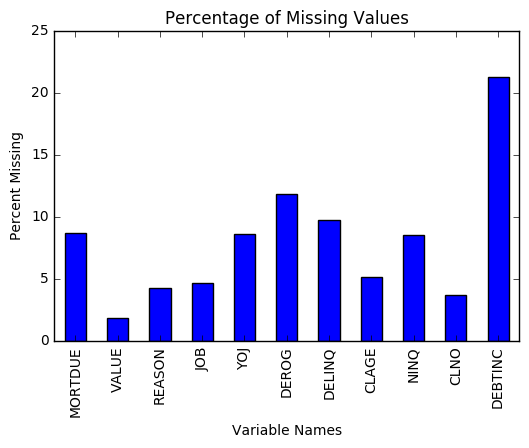

In [10]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names')

### Impute missing values

In [11]:
# Pipelined imputation using transform action
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"RANDOM"}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesContinuous":{50, 100}}, "inputs":{"debtinc", "yoj"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod          Seed
 0       _TR1           1         Mean           NaN
 1       _TR2           1       Median           NaN
 2       _TR3           1       Random  1.801404e+09
 3       _TR4           2        Value           NaN

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275
 1  DEBTINC             IM  IM_DEBTINC  4693   1267              100.000000
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000
 3     NINQ             IM     IM_NINQ  5450    510                     NaN
 4      YOJ             IM      IM_YOJ  5445    515               50.000000

[OutputCasTables]

               casLib          Name  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyau...  

+ Elapsed: 0.0199s, user: 0.019s, sys: 0.004s, mem: 9.52mb

### Identify variables that explain variance in the target

NOTE: The CAS table 'SelectionSummary' in caslib 'CASUSER(viyauser)' has 9 rows and 9 columns.


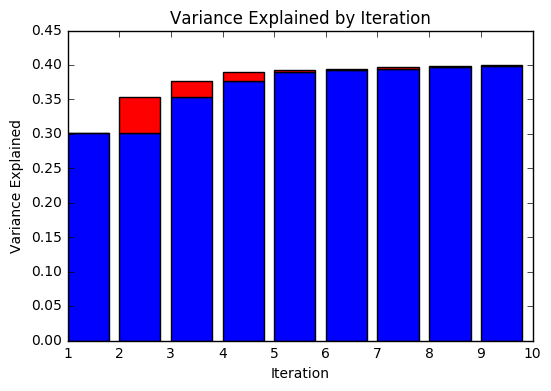

In [12]:
#/* Discriminant analysis for class target */
sess.varReduce.super(
  table={"name":"hmeq_prepped"},
  analysis="DSC",
  classVars=[{"vars":{"bad", "reason", "job"}}],
  model={
    "depVars":[{"name":target}],
    "effects":[{"vars":{"reason", "job", "im_clage", "clno", 
                        "im_debtinc", "loan", "mortdue", "value",
                        "im_yoj", "im_ninq", "derog", "im_delinq"}}]
  },
  maxeffects=8,
  outputTables={"names":{"SelectionSummary"}}  
)

# Compute Increment and Base variables
selsum=sess.CASTable("SelectionSummary")
selsum.vars=['Iteration', 'Variable', 'VarExp']
allRows=20000  # Assuming max rows in SelectionSummary table is <= 20,000
plot_df=selsum.fetch(to=allRows)['Fetch']
 
plot_df["Increment"]=0
prevVarExp=0
for i, row in plot_df.iterrows():
    if i==0:
        prevVarExp=row["VarExp"]
    else:
        plot_df.loc[i, "Increment"]=row["VarExp"]-prevVarExp
        prevVarExp=row["VarExp"]
plot_df["Base"]=plot_df["VarExp"]-plot_df["Increment"]

#/* Variance explained by Iteration plot */       
plt.bar(plot_df["Iteration"], plot_df["Base"], color='b')
plt.bar(plot_df["Iteration"], plot_df["Increment"], color='r', bottom=plot_df["Base"])
plt.xlabel("Iteration")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Iteration")
plt.show()

### Perform a cluster analysis based on demographic inputs

In [13]:
sess.clustering.kClus(
  table={"name":"hmeq_prepped"},
  inputs={"im_clage", "im_debtinc", "value"},
  distance="EUCLIDEAN",
  standardize="STD",
  nClusters=6
)

NOTE: Using SEED=1308098652.
NOTE: Running for input data for K 6.
NOTE: Clustering is finished. MAXITER is satisfied.


,Type,N
0,Number of Observations Read,5960.0
1,Number of Observations Used,5848.0
,Parameter,Setting
0,Clustering Algorithm,K-means
1,Maximum Iterations,10
2,Stop Criterion,Cluster Change
3,Stop Criterion Value,0
4,Clusters,6
5,Initialization,Forgy
6,Seed,1308098652


### Perform a principal components analysis on the interval valued input variables   

In [14]:
sess.pca.eig(
  table={"name":"hmeq_prepped"},
  inputs={"im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", 
          "im_yoj", "im_ninq"}
)

[ModelInfo]

 Model Information
 
                    Description                     Value
 0                  Data Source              HMEQ_PREPPED
 1  Component Extraction Method  Eigenvalue Decomposition

[NVars]

 Number of Variables
 
                       Description  Value
 0             Number of Variables      8
 1  Number of Principal Components      8

[NObs]

 Number of Observations
 
                    Description   Value
 0  Number of Observations Read  5960.0
 1  Number of Observations Used  5222.0

[SimpleStatistics]

 Simple Statistics
 
      Variable           Mean        StdDev
 0       VALUE  105354.566871  54494.538540
 1  IM_DEBTINC      47.640716     27.411594
 2        LOAN   18738.280352  11127.083435
 3        CLNO      22.000766      9.967732
 4      IM_YOJ      11.089812     11.642771
 5    IM_CLAGE     179.421355     83.850278
 6     IM_NINQ       1.476895      2.381002
 7     MORTDUE   73946.121195  44491.936830

[Corr]

 Correlation Matrix
 
      Variable     VALUE  IM_DEBTINC      LOAN      CLNO    IM_YOJ  IM_CLAGE  \
 0       VALUE  1.000000   -0.032469  0.351342  0.242676 -0.022987  0.191939   
 1  IM_DEBTINC -0.032469    1.000000 -0.075826  0.035880 -0.027993 -0.092379   
 2        LOAN  0.351342   -0.075826  1.000000  0.063744  0.124396  0.094256   
 3        CLNO  0.242676    0.035880  0.063744  1.000000 -0.040125  0.247441   
 4      IM_YOJ -0.022987   -0.027993  0.124396 -0.040125  1.000000  0.173651   
 5    IM_CLAGE  0.191939   -0.092379  0.094256  0.247441  0.173651  1.000000   
 6     IM_NINQ  0.008096    0.093619  0.024313  0.075538 -0.032430 -0.067882   
 7     MORTDUE  0.874882   -0.024348  0.228672  0.324466 -0.105647  0.137154   
 
     IM_NINQ   MORTDUE  
 0  0.008096  0.874882  
 1  0.093619 -0.024348  
 2  0.024313  0.228672  
 3  0.075538  0.324466  
 4 -0.032430 -0.105647  
 5 -0.067882  0.137154  
 6  1.000000  0.026317  
 7  0.026317  1.000000  

[Eigenvalues]

 Eigenvalues of the Correlation Matrix
 
    Number  Eigenvalue  Difference  Proportion  Cumulative
 0       1    2.258006    0.994227    0.282251    0.282251
 1       2    1.263778    0.188991    0.157972    0.440223
 2       3    1.074787    0.049939    0.134348    0.574571
 3       4    1.024848    0.118047    0.128106    0.702677
 4       5    0.906801    0.194759    0.113350    0.816027
 5       6    0.712041    0.060127    0.089005    0.905033
 6       7    0.651914    0.544089    0.081489    0.986522
 7       8    0.107825         NaN    0.013478    1.000000

[Eigenvectors]

 Eigenvectors
 
      Variable     Prin1     Prin2     Prin3     Prin4     Prin5     Prin6  \
 0       VALUE -0.606495  0.091457 -0.177225 -0.082156 -0.121851  0.258176   
 1  IM_DEBTINC  0.052924  0.407384  0.465157 -0.192238 -0.730262 -0.122987   
 2        LOAN -0.316322 -0.227871 -0.172822 -0.563881  0.016803 -0.699319   
 3        CLNO -0.335635  0.078482  0.490129  0.376003  0.148371 -0.338840   
 4      IM_YOJ  0.005601 -0.607510  0.307846 -0.408019 -0.196374  0.427327   
 5    IM_CLAGE -0.248867 -0.475319  0.411879  0.323593  0.057027 -0.050270   
 6     IM_NINQ -0.025394  0.365567  0.441558 -0.473830  0.616818  0.188985   
 7     MORTDUE -0.595013  0.197368 -0.150795  0.035356 -0.085403  0.305793   
 
       Prin7     Prin8  
 0 -0.072934 -0.706271  
 1 -0.171364  0.011674  
 2 -0.039085  0.096589  
 3  0.597030 -0.079457  
 4  0.383531  0.037219  
 5 -0.655316  0.050622  
 6 -0.173242 -0.005983  
 7  0.028198  0.693843  

[Timing]

 Task Timing
 
                              Task      Time   RelTime
 0               Setup and Parsing  0.001388  0.377488
 1               Computing Moments  0.000645  0.175452
 2  Computing Principal Components  0.001636  0.444920
 3                         Cleanup  0.000002  0.000584
 4                           Total  0.003677  1.000000

+ Elapsed: 0.00574s, user: 0.002s, sys: 0.004s, mem: 0.671mb

### End CAS session

In [15]:
sess.close()